In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import sklearn.preprocessing as preprocess
from collections import Counter
import pprint
from scipy.stats import chisquare
from sklearn.decomposition import PCA
import seaborn as sns

pp = pprint.PrettyPrinter(indent=4)

## Reorganize data

In [32]:
#unique songs df, drop categorical features
unique_df = pd.read_csv("TopCharts_unique.csv", index_col = 0).drop(columns = ["Instrumentalness", "Time Signature", "Key", "Mode"])

In [33]:
unique_df.columns

Index(['Artist', 'Title', 'Id', 'Tempo', 'Valence', 'Danceability', 'Energy',
       'Acousticness', 'Days'],
      dtype='object')

In [34]:
cont_cols = list(unique_df.columns[3:8])

In [35]:
#get 25th, 50th, 75th quantiles of continuous features for each artist 
cols = ["Artist", "Total_Days"]
qs = ["q25", "q50", "q75"]
for c in cont_cols:
    cols.extend([q + c for q in qs])
d = {c:[] for c in cols}

for a in unique_df.Artist.unique():
    s = unique_df.loc[unique_df.Artist == a, :]
    d["Total_Days"].append(s.Days.sum())
    
    sub = s.loc[unique_df.Artist == a, cont_cols]
    d["Artist"].append(a)
    for q in qs:
        quant = int(q[1:])
        data = dict(sub.quantile(q = quant/100))
        for k in data.keys():
            d[q+k].append(data[k])

In [36]:
artist_df = pd.DataFrame(d)

In [37]:
artist_df.head()

,Artist,Total_Days,q25Tempo,q50Tempo,q75Tempo,q25Valence,q50Valence,q75Valence,q25Danceability,q50Danceability,q75Danceability,q25Energy,q50Energy,q75Energy,q25Acousticness,q50Acousticness,q75Acousticness
0,Post Malone,8033,101.23675,133.0240,149.06250,0.23200,0.324,0.45725,0.57050,0.6310,0.71675,0.55225,0.6495,0.73375,0.124000,0.20650,0.41075
1,G-Eazy,539,97.95300,100.0130,160.01400,0.26100,0.645,0.70400,0.58900,0.8170,0.83900,0.70500,0.7430,0.77100,0.011700,0.05340,0.07380
2,Lil Pump,396,125.02000,139.9770,148.03500,0.45750,0.549,0.69500,0.87400,0.9250,0.93500,0.48400,0.5050,0.56000,0.009485,0.02290,0.14295
3,Cardi B,2041,128.73825,133.9875,141.58100,0.26175,0.454,0.56375,0.80225,0.8605,0.91250,0.53850,0.5700,0.64450,0.028150,0.06505,0.11875
4,Camila Cabello,974,94.66425,104.9880,120.56175,0.27225,0.394,0.55075,0.56350,0.6755,0.73550,0.49625,0.5355,0.66250,0.151750,0.19700,0.41575


In [38]:
artist_df.to_csv("ArtistData.csv")

## K-means clustering (no dim reduction)

In [39]:
#clustering on these features
cluster_cols = artist_df.columns[2:]

In [40]:
cluster_cols

Index(['q25Tempo', 'q50Tempo', 'q75Tempo', 'q25Valence', 'q50Valence',
       'q75Valence', 'q25Danceability', 'q50Danceability', 'q75Danceability',
       'q25Energy', 'q50Energy', 'q75Energy', 'q25Acousticness',
       'q50Acousticness', 'q75Acousticness'],
      dtype='object')

In [41]:
def scaleData(scaler, df, col_list = cluster_cols):
    
    """
    normalizes continuous values in dataframe
    
    inputs:  scaler:    one of the scaler functions from sklearn.preprocessing
             song_df:   dataframe of songs (with titles) 
             firstCol:  index of first column of continuous values to be rescaled in song_df 
    
    returns: dataframe of songs (with titles) with rescaled continuous values
    """
    
    scaled_df = df.copy()
        
    cluster_values = df.loc[:,col_list]
    mms = scaler()
    scaled_values = mms.fit_transform(cluster_values)
    
    for i in range(scaled_values.shape[1]):
        scaled_df[col_list[i]] = scaled_values[:,i]

    return scaled_df

In [42]:
scaled_df = scaleData(preprocess.MinMaxScaler, artist_df)

In [43]:
scaled_df.head()

,Artist,Total_Days,q25Tempo,q50Tempo,q75Tempo,q25Valence,q50Valence,q75Valence,q25Danceability,q50Danceability,q75Danceability,q25Energy,q50Energy,q75Energy,q25Acousticness,q50Acousticness,q75Acousticness
0,Post Malone,8033,0.355808,0.563263,0.653745,0.184208,0.280623,0.426746,0.504258,0.577859,0.682178,0.534492,0.641832,0.734823,0.124716,0.207632,0.413145
1,G-Eazy,539,0.334378,0.347822,0.723700,0.215836,0.632635,0.697335,0.526764,0.804136,0.830900,0.703091,0.745033,0.775938,0.011733,0.053586,0.074112
2,Lil Pump,396,0.511026,0.608641,0.647182,0.430145,0.527360,0.687466,0.873479,0.935523,0.947689,0.459161,0.482340,0.543046,0.009505,0.022898,0.143690
3,Cardi B,2041,0.535293,0.569551,0.605956,0.216654,0.423182,0.543535,0.786192,0.857056,0.920316,0.519316,0.554084,0.636313,0.028283,0.065308,0.119340
4,Camila Cabello,974,0.312914,0.380290,0.471691,0.228106,0.357386,0.529280,0.495742,0.631995,0.704988,0.472682,0.516004,0.656181,0.152634,0.198074,0.418176


In [44]:
def plotKMeans(scaled_df, minCluster, maxCluster, col_list):
    """
    applies k-means clustering to dataframe and plots inertia and change in inertia for corresponding to number of clusters
    
    inputs:   df:          dataframe with only continuous values
              minCluster:  smallest number of desired clusters
              maxClusters: largest number of desired clusters
              col_list:    columns to cluster on
    
    returns:  list of intertias corresponding to number of clusters ranging from minCluster to maxCluster
    
    """

    df = scaled_df.loc[:,col_list]
    
    
    inertias = []
    for i in range(minCluster, maxCluster+1):
        kmeans = KMeans(n_clusters = i).fit(df)
        inertias.append(kmeans.inertia_)    
    
    plt.plot(range(1,len(inertias)+1), inertias, "bx-")
    plt.xlabel('k')
    plt.ylabel("Inertia")
    plt.xticks(range(1,len(inertias)+1))
    plt.show()
    
    
    diffs = np.array(inertias[1:]) - np.array(inertias[:len(inertias)-1])
    plt.plot(range(1,len(inertias)+1), [-inertias[0]] + list(diffs),"bx-")
    plt.ylabel("Change in Inertia")
    plt.xticks(range(1,len(inertias)+1))

    plt.show()
    
    return inertias

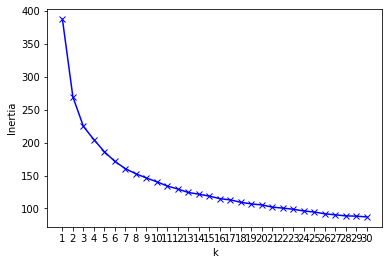

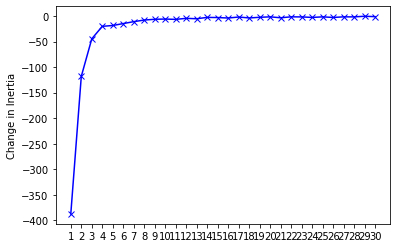

In [45]:
inertias = plotKMeans(scaled_df, 1, 30, cluster_cols)

In [46]:
k = 8

In [47]:
def sort_df(df, k):
    df = df.sort_values(by = "Label").reset_index(drop = True)

    for i in range(k):
        sub = df.loc[df.Label == i]
        first = sub.index[0]
        last = sub.index[-1]+1
        df.iloc[first:last, :] = sub.sort_values(by = "Total_Days", ascending = False).values
    
    return df.reset_index(drop = True)

In [48]:
def fitKMeans(scaled_df, k, col_list):
    """
    applies k-means clustering with k clusters to dataframe
    
    inputs:   song_df:      dataframe of songs (with titles)
              clusters:  number of desired clusters
              col_list: list of column indexes to cluster on
            
    returns:  dataframe of songs with cluster number
              dict of dataframes {cluster number: subset of song_df with songs belonging to cluster}
              dict of Counters   {cluster number: Counter(artist, number of times artist appears in cluster)}
    """
    
    kmeans_opt = KMeans(n_clusters = k).fit(scaled_df.loc[:,col_list])
    labels_df = scaled_df.copy()
    labels_df["Label"] = kmeans_opt.labels_
    
    return sort_df(labels_df, k)

In [49]:
cluster_df = fitKMeans(scaled_df, k, cluster_cols)

In [50]:
cluster_df

,Artist,Total_Days,q25Tempo,q50Tempo,q75Tempo,q25Valence,q50Valence,q75Valence,q25Danceability,q50Danceability,q75Danceability,q25Energy,q50Energy,q75Energy,q25Acousticness,q50Acousticness,q75Acousticness,Label
0,Marshmello,1704,0.331552,0.522748,0.608626,0.185844,0.406733,0.590416,0.459246,0.576642,0.639903,0.665011,0.831126,0.907285,0.017720,0.040808,0.144947,0
1,Luke Combs,1396,0.279447,0.510922,0.618535,0.503490,0.610155,0.672387,0.412105,0.469586,0.483577,0.763245,0.822296,0.874172,0.012136,0.048052,0.308251,0
2,6ix9ine,1303,0.316649,0.530413,0.605579,0.345348,0.496655,0.618105,0.634732,0.708029,0.756691,0.670254,0.775938,0.857064,0.032408,0.078338,0.125126,0
3,Logic,1280,0.314723,0.589137,0.696591,0.310994,0.577805,0.742570,0.624088,0.715937,0.809307,0.680740,0.782561,0.853201,0.055397,0.110536,0.169649,0
4,5 Seconds of Summer,827,0.480052,0.647838,0.723145,0.562657,0.603027,0.770808,0.553528,0.562044,0.717762,0.498896,0.718543,0.839956,0.013243,0.016861,0.050970,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625,Cooliecut,1,0.477807,0.477807,0.467656,0.531028,0.528457,0.528457,0.688564,0.688564,0.688564,0.646799,0.646799,0.646799,0.653911,0.653874,0.653874,7
626,The Temptations,1,0.377536,0.377536,0.369515,0.688079,0.686369,0.686369,0.506083,0.506083,0.506083,0.386313,0.386313,0.386313,0.638819,0.638781,0.638781,7
627,The Beatles,1,0.508488,0.508488,0.497684,0.953103,0.952846,0.952846,0.396594,0.396594,0.396594,0.862031,0.862031,0.862031,0.644856,0.644818,0.644818,7
628,Tom Petty and the Heartbreakers,1,0.442447,0.442447,0.433047,0.778602,0.777388,0.777388,0.479319,0.479319,0.479319,0.834437,0.834437,0.834437,0.450684,0.450625,0.450625,7


In [51]:
def getCluster(cluster_df, cluster_idx, top = -1):
    artists = list(cluster_df[cluster_df.Label == cluster_idx].Artist)
    if top == -1:
        return {cluster_idx: artists}
    else:
        return {cluster_idx: artists[:min(top, len(artists))]}

In [52]:
for i in range(k):
    pp.pprint(getCluster(cluster_df, i, top = 10))

{   0: [   'Marshmello',
           'Luke Combs',
           '6ix9ine',
           'Logic',
           '5 Seconds of Summer',
           'Lizzo',
           'Panic! At The Disco',
           'Jonas Brothers',
           'Dua Lipa',
           'G-Eazy']}
{   1: [   'XXXTENTACION',
           'Billie Eilish',
           'Sam Smith',
           'Joji',
           'Metro Boomin',
           'H.E.R.',
           'Lady Gaga',
           'Mac Miller',
           'Demi Lovato',
           'Ali Gatie']}
{   2: [   'Lewis Capaldi',
           'Bing Crosby',
           'Frank Sinatra',
           'Dean Martin',
           'Nat King Cole',
           'Lana Del Rey',
           'Jeremy Zucker',
           'Idina Menzel',
           'JP Saxe',
           'Elvis Presley']}
{   3: [   'DaBaby',
           'Famous Dex',
           'BlocBoy JB',
           'Flipp Dinero',
           'Bruno Mars',
           'Daddy Yankee',
           'Anuel AA',
           'Nicky Jam',
           'Tiësto',
           'S

## Un-scale features

In [53]:
label_artist_df = artist_df.copy()
for i in range(len(cluster_df)):
    row = cluster_df.loc[i,:]
    label_artist_df.loc[label_artist_df.Artist == row["Artist"], "Label"] = int(row["Label"])
label_artist_df = sort_df(label_artist_df, k)

In [54]:
label_artist_df.head()

,Artist,Total_Days,q25Tempo,q50Tempo,q75Tempo,q25Valence,q50Valence,q75Valence,q25Danceability,q50Danceability,q75Danceability,q25Energy,q50Energy,q75Energy,q25Acousticness,q50Acousticness,q75Acousticness,Label
0,Marshmello,1704,97.52000,126.8160,141.99900,0.23350,0.4390,0.60650,0.53350,0.6300,0.68200,0.67050,0.821,0.8900,0.01765,0.0407,0.14420,0.0
1,Luke Combs,1396,89.53625,125.0040,143.55025,0.52475,0.6245,0.68125,0.49475,0.5420,0.55350,0.75950,0.813,0.8600,0.01210,0.0479,0.30650,0.0
2,6ix9ine,1303,95.23650,127.9905,141.52200,0.37975,0.5210,0.63175,0.67775,0.7380,0.77800,0.67525,0.771,0.8445,0.03225,0.0780,0.12450,0.0
3,Logic,1280,94.94150,136.9885,155.77000,0.34825,0.5950,0.74525,0.66900,0.7445,0.82125,0.68475,0.777,0.8410,0.05510,0.1100,0.16875,0.0
4,5 Seconds of Summer,827,120.27400,145.9830,159.92700,0.57900,0.6180,0.77100,0.61100,0.6180,0.74600,0.52000,0.719,0.8290,0.01320,0.0169,0.05080,0.0


In [55]:
label_artist_df.to_csv("ArtistData_clustered.csv")